In [25]:
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv

from scipy import ndimage as ndi

from skimage import data, measure, morphology, color, filters, exposure, feature
from skimage.morphology import disk, opening
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.filters import frangi, hessian

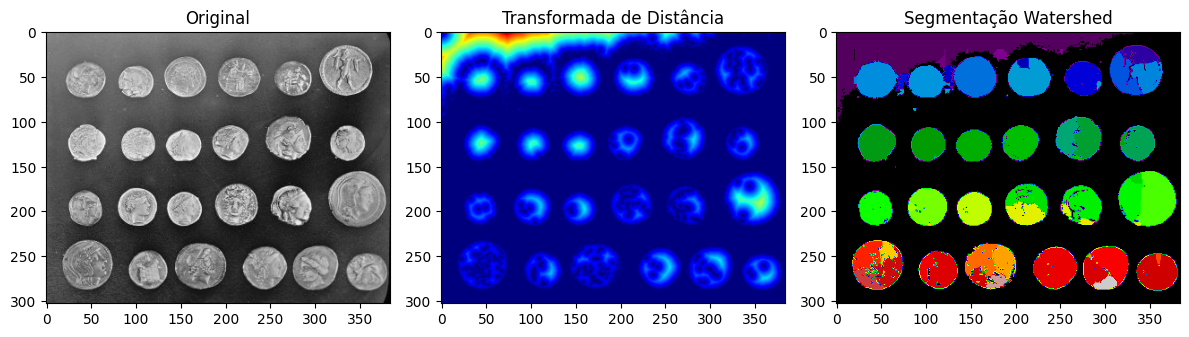

In [26]:
coins = data.coins()

threshold = 100
binary = coins > threshold

# transformada de distância
distance = ndi.distance_transform_edt(binary)

# Seeds pro watershed
coords = peak_local_max(distance, labels=binary, footprint=np.ones((3, 3)), min_distance=20)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

labels = watershed(-distance, markers, mask=binary)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(coins, cmap='gray')
plt.title('Original')

plt.subplot(132)
plt.imshow(distance, cmap='jet')
plt.title('Transformada de Distância')

plt.subplot(133)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Segmentação Watershed')
plt.tight_layout()
plt.show()

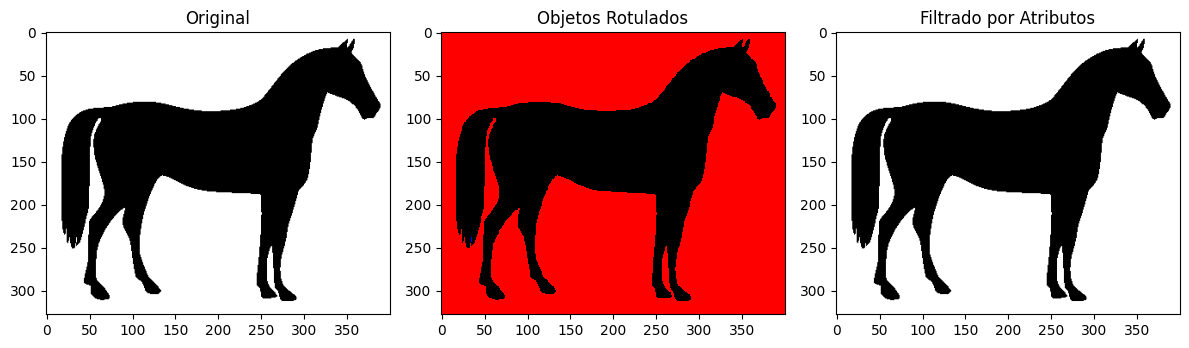

Objeto 1:
  Área: 87782.0
  Perímetro: 3736.69
  Excentricidade: 0.52
Objeto 2:
  Área: 6.0
  Perímetro: 4.00
  Excentricidade: 1.00


In [27]:
image = data.horse()
binary = image > 0

# Rotula componentes conectados
labeled, num_features = ndi.label(binary)

# Mensura propriedades para cada objeto
props = measure.regionprops(labeled)

#filtra pelas propriedades
filtered_img = np.zeros_like(binary)

for region in props:

    if region.area > 1000 and region.eccentricity < 0.9:
        coords = region.coords
        filtered_img[coords[:, 0], coords[:, 1]] = 1

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(132)
plt.imshow(color.label2rgb(labeled, bg_label=0), interpolation='nearest')
plt.title('Objetos Rotulados')

plt.subplot(133)
plt.imshow(filtered_img, cmap='gray')
plt.title('Filtrado por Atributos')
plt.tight_layout()
plt.show()

for i, prop in enumerate(props[:5]):
    print(f"Objeto {i+1}:")
    print(f"  Área: {prop.area}")
    print(f"  Perímetro: {prop.perimeter:.2f}")
    print(f"  Excentricidade: {prop.eccentricity:.2f}")

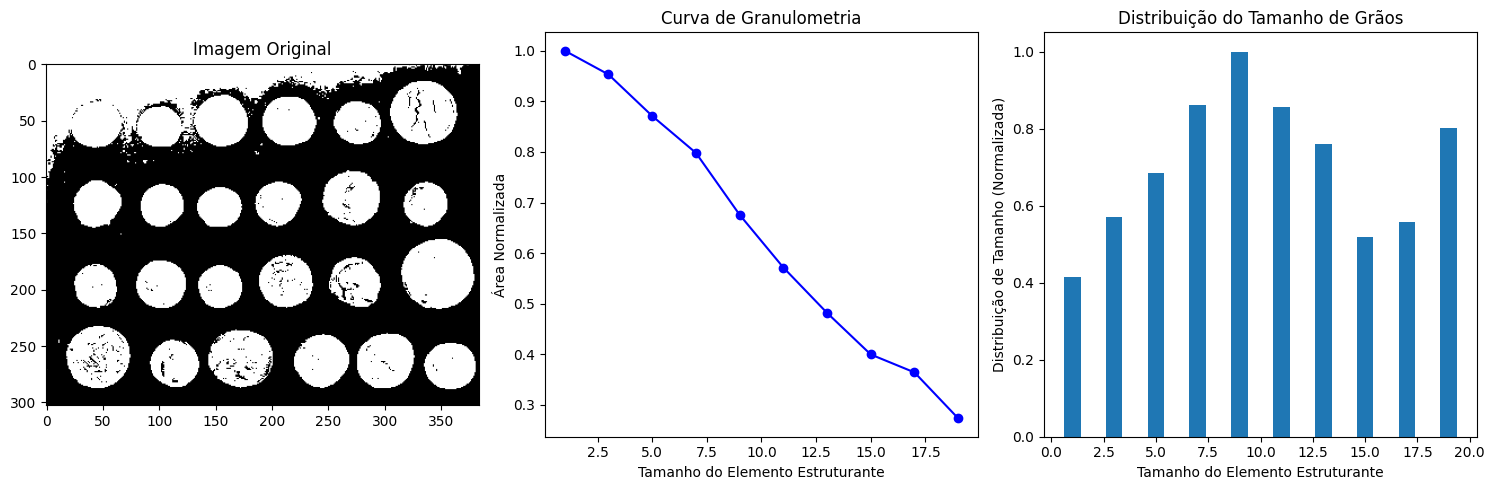

In [31]:
binary = data.coins() > 100

# Granulometria - tamanho de grão
def granulometry(image, sizes=range(1, 20, 2)):
    granulo = []

    for size in sizes:
        # Abertura com SE / abertura 
        opened = opening(image, disk(size))
        granulo.append(np.sum(opened))
    
    # Calcula distribuição de tamanho (derivada da curva de granulometria)
    sizes_array = np.array(sizes)
    granulo_array = np.array(granulo)
    distribution = np.abs(np.gradient(granulo_array))
    
    return sizes_array, granulo_array, distribution

sizes, granulo, distribution = granulometry(binary)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(binary, cmap='gray')
plt.title('Imagem Original')

plt.subplot(132)
plt.plot(sizes, granulo/granulo[0], 'bo-')
plt.xlabel('Tamanho do Elemento Estruturante')
plt.ylabel('Área Normalizada')
plt.title('Curva de Granulometria')

plt.subplot(133)
plt.bar(sizes, distribution/np.max(distribution), width=0.8)
plt.xlabel('Tamanho do Elemento Estruturante')
plt.ylabel('Distribuição de Tamanho (Normalizada)')
plt.title('Distribuição do Tamanho de Grãos')
plt.tight_layout()
plt.show()

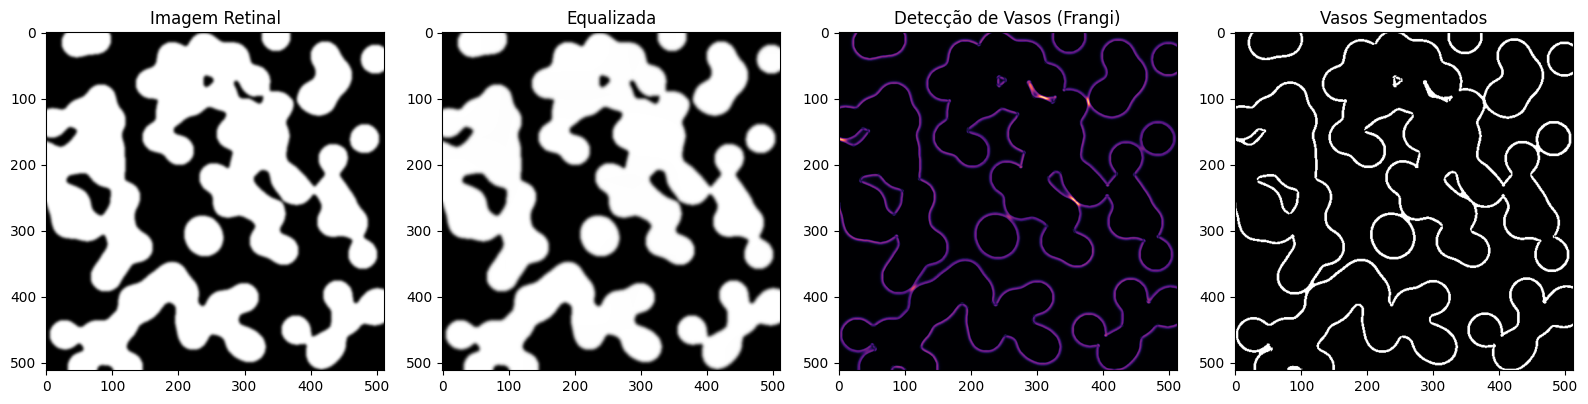

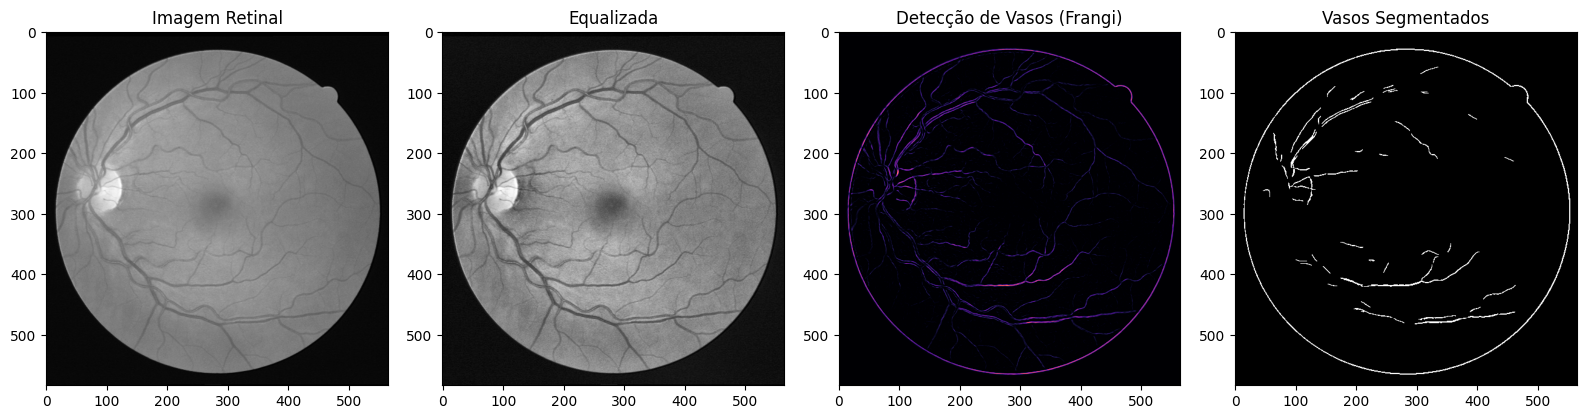

In [50]:
import os

caminho = "/Users/luryand/Documents/DPI/dip-2024-2/img/01_test.tif"

retina_img = cv.imread(caminho, cv.IMREAD_GRAYSCALE)
retina = retina_img.astype(float) / 255.0

retina_eq = exposure.equalize_adapthist(retina)

# Detecção de vasos usando filtro de Frangi
vessels_frangi = frangi(retina_eq, sigmas=range(1, 10, 2))
vessels_frangi = (vessels_frangi - vessels_frangi.min()) / (vessels_frangi.max() - vessels_frangi.min())

# Detector OTSU - Binarização
threshold = filters.threshold_otsu(vessels_frangi)
vessels_binary = vessels_frangi > threshold

# Limpeza morfológica
vessels_cleaned = morphology.remove_small_objects(vessels_binary, min_size=20)
vessels_cleaned = morphology.remove_small_holes(vessels_cleaned, area_threshold=50)

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(retina, cmap='gray')
plt.title('Imagem Retinal')

plt.subplot(142)
plt.imshow(retina_eq, cmap='gray')
plt.title('Equalizada')

plt.subplot(143)
plt.imshow(vessels_frangi, cmap='magma')
plt.title('Detecção de Vasos (Frangi)')

plt.subplot(144)
plt.imshow(vessels_cleaned, cmap='gray')
plt.title('Vasos Segmentados')

plt.tight_layout()
plt.show()

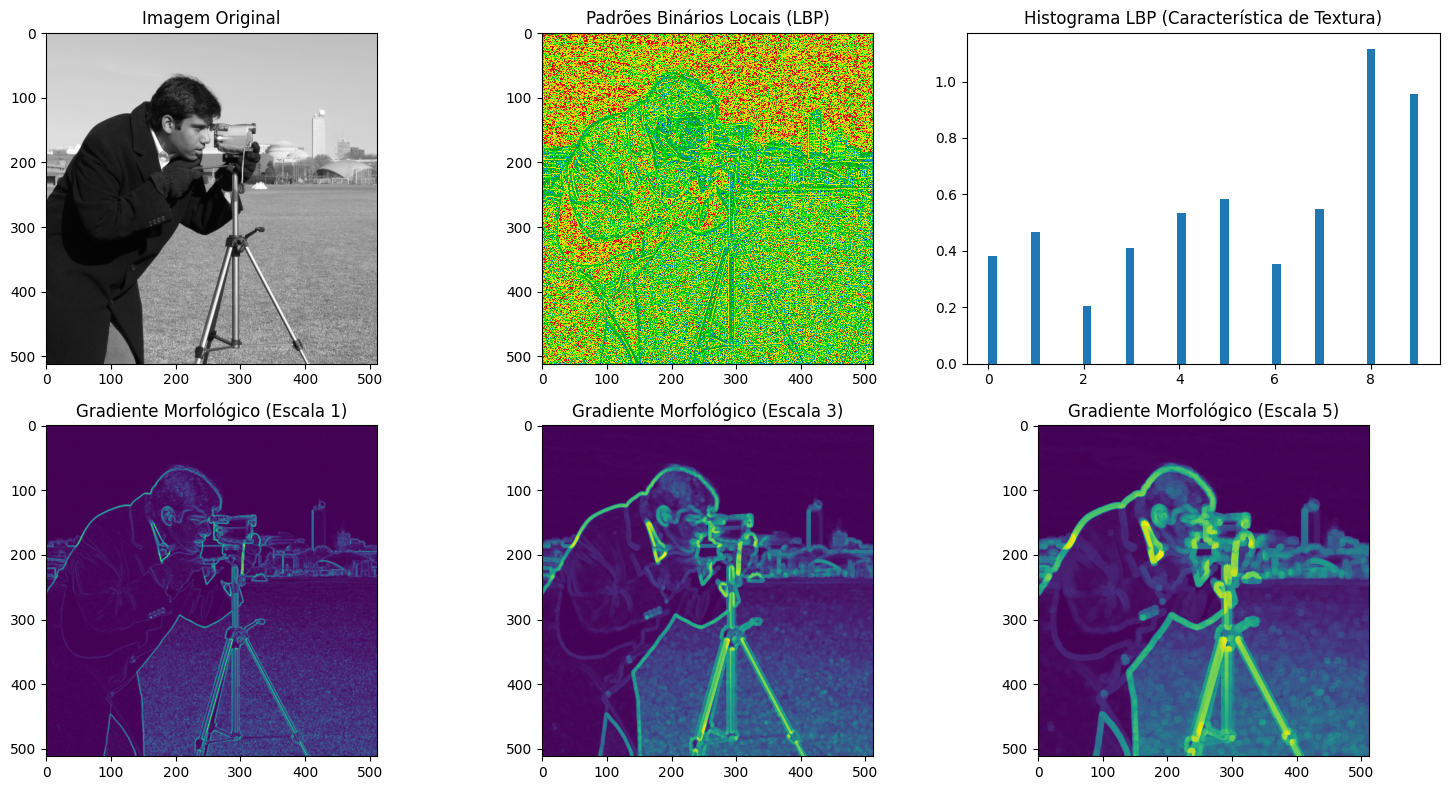

In [ ]:
# Encontrei essa imagem mostrada em aula na lib, aproveitei e usei como exemplo
image = data.camera()

# Técnica 1: Padrões Binários Locais (LBP) com base morfológica
lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')

# Técnica 2: Gradiente morfológico multi-escala
def multiscale_gradient(image, scales):
    results = []
    for s in scales:
        se = morphology.disk(s)
        dilated = morphology.dilation(image, se)
        eroded = morphology.erosion(image, se)
        gradient = dilated - eroded
        results.append(gradient)
    return results

# Gradientes multiescalares
gradients = multiscale_gradient(image, scales=[1, 3, 5])

plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(232)
plt.imshow(lbp, cmap='nipy_spectral')
plt.title('Padrões Binários Locais (LBP)')

plt.subplot(233)
plt.hist(lbp.ravel(), bins=50, density=True)
plt.title('Histograma LBP (Característica de Textura)')

for i, (scale, gradient) in enumerate(zip([1, 3, 5], gradients)):
    plt.subplot(2, 3, 4+i)
    plt.imshow(gradient, cmap='viridis')
    plt.title(f'Gradiente Morfológico (Escala {scale})')

plt.tight_layout()
plt.show()